# **P**rincipal **O**rthogonal **L**atent **C**omponents **A**nalysis Net (POLCA-Net)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import ipywidgets as widgets
import matplotlib.pyplot as plt
import seaborn
plt.style.use("seaborn-v0_8-paper")
import numpy as np
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"

from sklearn import datasets, decomposition

In [3]:
from polcanet import PolcaNet, LinearDecoder
from polcanet.example_aencoders import autoencoder_factory, StandardScalerTorch, MinMaxScalerTorch

In [4]:
from polcanet.polcanet_reports import analyze_latent_space, show_correlation_matrix, plot_scatter_corr_matrix, plot_stdev_pct, \
    plot_cumsum_variance, analyze_latent_feature_importance, analyze_reconstruction_error, orthogonality_test_analysis, \
    variance_test_analysis, linearity_tests_analysis

In [5]:
np.random.seed(5)

In [6]:
torch.autograd.set_detect_anomaly(False)
torch.autograd.profiler.profile(False)
torch.autograd.profiler.emit_nvtx(False)

### Load dataset

In [7]:
import torchvision.datasets as datasets
datasets.MNIST
mnist_trainset = datasets.MNIST(root='../../data', train=True, download=True, transform=None)

In [8]:
train_dataset = mnist_trainset.data[:-10000].reshape(-1,1,  28, 28) / 255.
eval_dataset = mnist_trainset.data[-10000:].reshape(-1,1,  28, 28) / 255.
X = np.array(train_dataset.numpy(),dtype=np.float32)
X = np.squeeze(X)
train_dataset.shape, eval_dataset.shape, X.shape

(torch.Size([50000, 1, 28, 28]),
 torch.Size([10000, 1, 28, 28]),
 (50000, 28, 28))

### Fit standard sklearn PCA

In [9]:
# pca = decomposition.PCA(n_components=8)
# pca.fit(np.squeeze(X))
# Xpca = pca.transform(X)
# pca.explained_variance_ratio_

### Fit POLCANet

In [11]:
N = X[0].shape[0]
M = X[0].shape[1]

ae_input = X
act_fn = torch.nn.SiLU
input_dim = ae_input[0].shape
latent_dim = 64
assert N==input_dim[0], "input_dim[0] should match first matrix dimension N"
assert M==input_dim[1], "input_dim[1] should match second matrix dimension M"

encoder_conv = autoencoder_factory(
    seq_len=input_dim[0], #    N
    input_dim=input_dim[1], #  M
    latent_dim=latent_dim,
    hidden_dim=None,
    num_layers=None,
    autoencoder_type="conv2d",    
    act_fn=act_fn,
)

decoder_conv = LinearDecoder(latent_dim=latent_dim*4,
                             input_dim=input_dim, 
                             hidden_dim=256, 
                             num_layers=3)

model = PolcaNet(
    encoder=encoder_conv,
    decoder=decoder_conv,
    latent_dim = latent_dim*4,
    alpha=0.1,  # ortgogonality loss
    beta=1.0,  # variance sorting loss
    gamma=1.0,  # variance reduction loss
    device="cuda:1",
    #scaler = StandardScalerTorch(),
)
model

PolcaNet(
  (encoder): ConvAutoencoder(
    (encoder): Sequential(
      (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): SiLU()
      (2): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (3): SiLU()
      (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (5): SiLU()
      (6): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (7): SiLU()
      (8): Flatten(start_dim=1, end_dim=-1)
    )
  )
  (decoder): LinearDecoder(
    (decoder): Sequential(
      (0): Linear(in_features=256, out_features=256, bias=True)
      (1): Linear(in_features=256, out_features=256, bias=True)
      (2): Linear(in_features=256, out_features=784, bias=True)
    )
  )
)

In [12]:
model.to("cuda:1")
model.train_model(data=X, batch_size= 512, num_epochs=10000, report_freq=100, lr=1e-3)

epoch:   0%|          | 0/10000 [00:00<?, ?it/s]

Final metrics at epoch: 9999
Total Loss: 0.001832
Reconstruction Loss: 0.001511
Orthogonality Loss: 0.002335
Center of Mass Loss: 4.535e-05
Variance Distribution Loss: 4.189e-05


In [13]:
model.train_model(data=X, batch_size= 512, num_epochs=1000, report_freq=100, lr=1e-4)

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Final metrics at epoch: 999
Total Loss: 0.001759
Reconstruction Loss: 0.001453
Orthogonality Loss: 0.002301
Center of Mass Loss: 3.534e-05
Variance Distribution Loss: 4.056e-05


In [14]:
model.train_model(data=X, batch_size= 512, num_epochs=1000, report_freq=100, lr=1e-5)

epoch:   0%|          | 0/1000 [00:00<?, ?it/s]

Final metrics at epoch: 999
Total Loss: 0.001751
Reconstruction Loss: 0.001448
Orthogonality Loss: 0.002292
Center of Mass Loss: 3.425e-05
Variance Distribution Loss: 3.991e-05


## Evaluate results

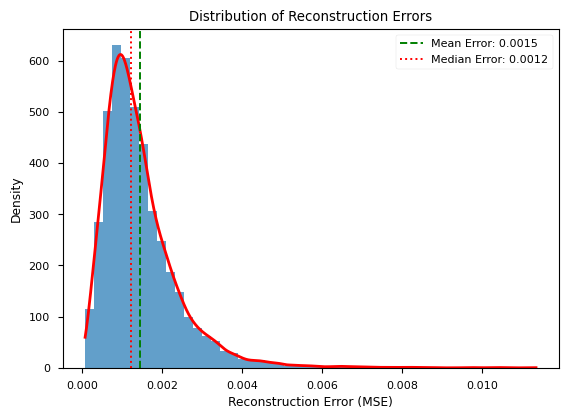

Mean Reconstruction Error: 0.0015
Median Reconstruction Error: 0.0012
Min Reconstruction Error: 0.0001
Max Reconstruction Error: 0.0113


In [15]:
analyze_reconstruction_error(model, X)

In [16]:
latents, reconstructed = model.predict(X)

In [17]:
analyze_latent_space(model, latents=latents)


           Latent Space Analysis Report           

1. General Information
------------------------------
Number of latent components: 256
Total variance in latent space: 75.2256

2. Variance Analysis
------------------------------
Metric                           Value
-----------------------------  -------
First component                 0.4349
First 5 components              1
Components for 95% variance     4
Variance Concentration Metric   0.9962

Variance Concentration Interpretation:
Excellent concentration of variance in earlier dimensions.

3. Orthogonality Analysis
------------------------------
Metric                                 Value
-----------------------------------  -------
Mean absolute off-diagonal            0.0084
Median absolute off-diagonal          0.0056
Max absolute off-diagonal             0.9973
Proportion of |Orthogonality| > 0.1   0.0011
Orthogonality Success Metric          0.9916

Orthogonality Interpretation:
Excellent orthogonality of features.

4.


    Orthogonality Test Analysis

    This report analyzes the orthogonality of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The orthogonality of the features is assessed by minimizing the cosine distance between the 
    latent features. The cosine similarity values between the features are summarized below:

    - Mean cosine similarity: -0.0001
    - Max cosine similarity: 0.9933
    - Min cosine similarity: -0.1616
    


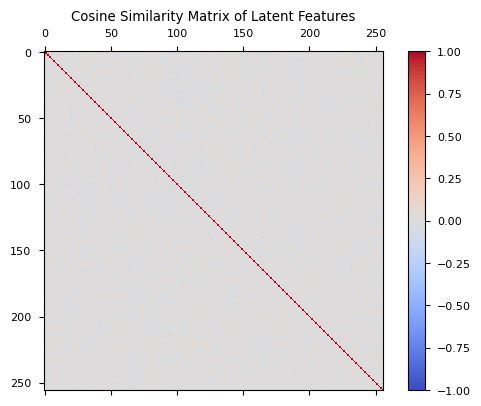

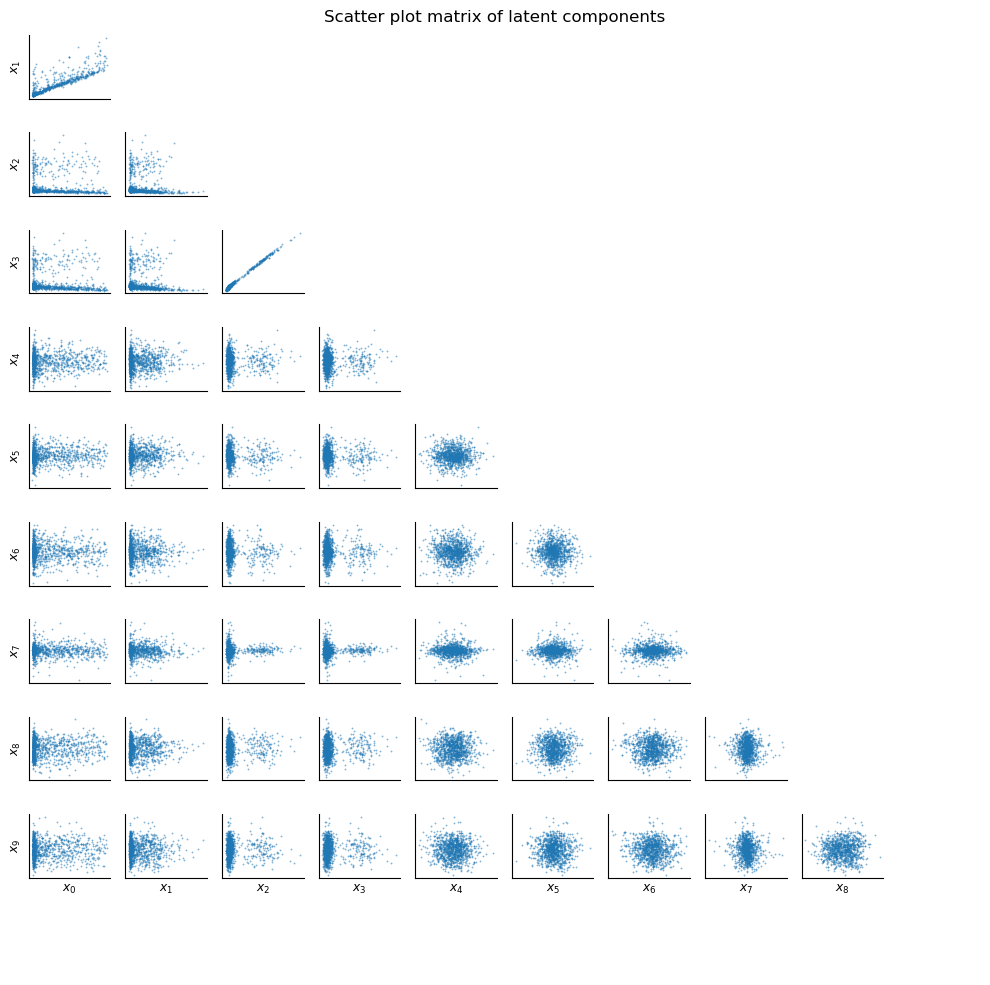

In [18]:
orthogonality_test_analysis(model, X)


    Variance Test Analysis

    This report analyzes the variance concentration of the latent features generated by the autoencoder.
    We used a sample size of 1000 randomly selected data points for the analysis.

    The variance concentration of the features is assessed by minimizing the center of mass of the 
    latent space and fitting the variance distribution to an exponential distribution. The results 
    are summarized below:

    - Center of mass: 1.9100
    - Variance fit to exponential distribution (sum of squared differences):
     0.0474
    


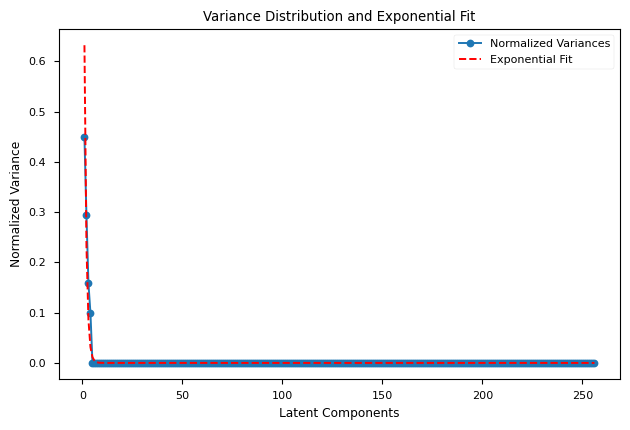

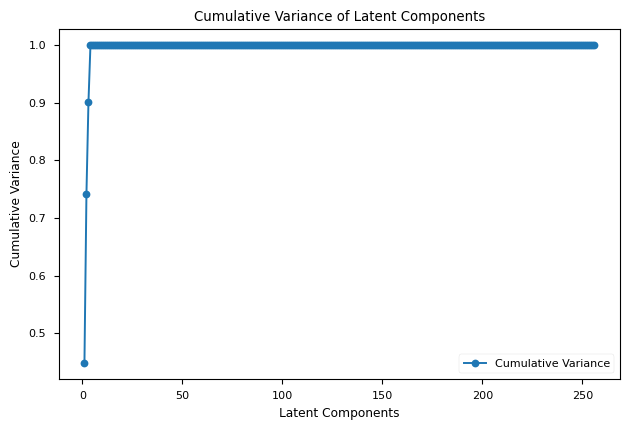

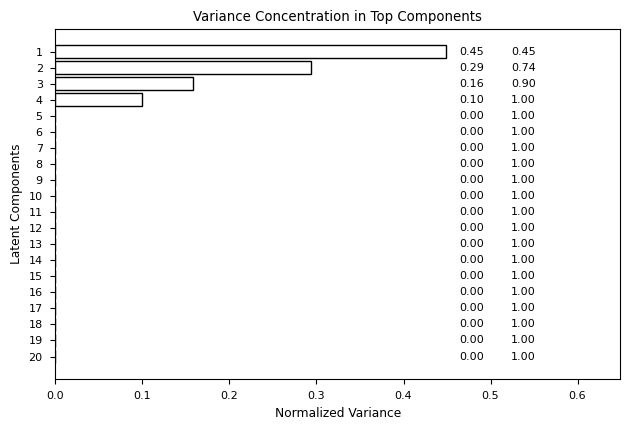

In [19]:
variance_test_analysis(model, X)


    Linearity Tests Analysis

    This report analyzes the linearity properties of the autoencoder. We used a sample size of 
    100 randomly selected data points for the analysis.

    The linearity properties of the features are assessed through two tests: additive property 
    and homogeneity property. The results are summarized below:

    1. Additive Property:
    ---------------------
    The additive property is tested to verify if:

    f(z_x + z_y) = f(z_x) + f(z_y)

    The differences between the left-hand side and the right-hand side of the equation are 
    summarized below:

    - Mean difference: 0.1207
    - Max difference: 0.6827
    - Min difference: 0.0000

    2. Homogeneity Property (Scalar alpha):
    ---------------------------------------
    The homogeneity property is tested to verify if:

    f(a.z_x) = a.f(z_x_)

    The differences between the left-hand side and the right-hand side of the equation are 
    summarized below:

    - Mean difference: 0.1070

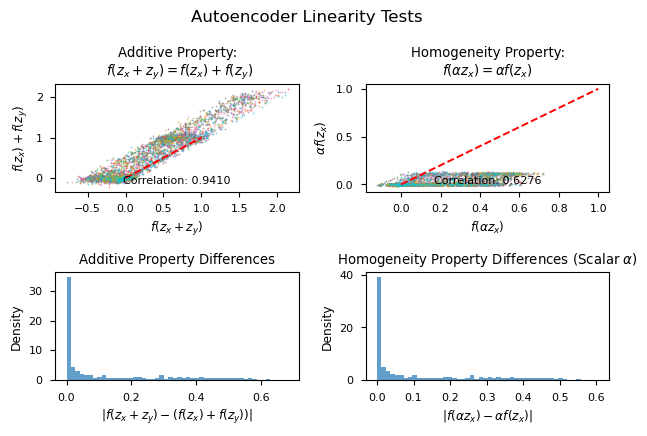

In [20]:
linearity_tests_analysis(model, X)

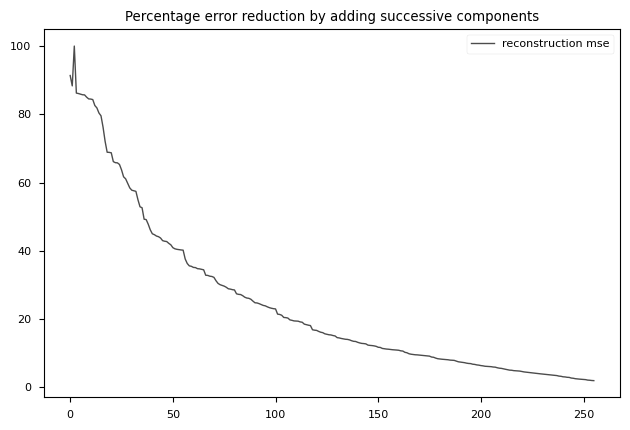

In [21]:
plot_cumsum_variance(model,X)

In [ ]:
from pythae.samplers import NormalSampler

In [ ]:
# create normal sampler
normal_samper = NormalSampler(
    model=trained_model
)

In [ ]:
# sample
gen_data = normal_samper.sample(
    num_samples=25
)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# show results with normal sampler
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(gen_data[i*5 +j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

In [ ]:
from pythae.samplers import GaussianMixtureSampler, GaussianMixtureSamplerConfig

In [ ]:
# set up GMM sampler config
gmm_sampler_config = GaussianMixtureSamplerConfig(
    n_components=10
)

# create gmm sampler
gmm_sampler = GaussianMixtureSampler(
    sampler_config=gmm_sampler_config,
    model=trained_model
)

# fit the sampler
gmm_sampler.fit(train_dataset)

In [ ]:
# sample
gen_data = gmm_sampler.sample(
    num_samples=25
)

In [ ]:
# show results with gmm sampler
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(gen_data[i*5 +j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

## ... the other samplers work the same

## Visualizing reconstructions

In [ ]:
reconstructions = trained_model.reconstruct(eval_dataset[:25].to(device)).detach().cpu()

In [ ]:
# show reconstructions
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(reconstructions[i*5 + j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

In [ ]:
# show the true data
fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))

for i in range(5):
    for j in range(5):
        axes[i][j].imshow(eval_dataset[i*5 +j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)

## Visualizing interpolations

In [ ]:
interpolations = trained_model.interpolate(eval_dataset[:5].to(device), eval_dataset[5:10].to(device), granularity=10).detach().cpu()

In [ ]:
# show interpolations
fig, axes = plt.subplots(nrows=5, ncols=10, figsize=(10, 5))

for i in range(5):
    for j in range(10):
        axes[i][j].imshow(interpolations[i, j].cpu().squeeze(0), cmap='gray')
        axes[i][j].axis('off')
plt.tight_layout(pad=0.)